In [2]:
!pip install kaggle


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\acerc\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
!pip install seaborn


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\acerc\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [4]:
!pip install scikit-learn


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\acerc\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [5]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0, InceptionV3
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [6]:
import os

# Settings
batch_size = 32
img_height = 224
img_width = 224

# Path to your dataset
data_dir = "Vegetable Images"

# Function to get class names from the directory
def get_class_names(data_dir):
    # Get absolute path
    absolute_path = os.path.abspath(data_dir)
    print(f"Checking directory: {absolute_path}")
    
    # Check if the directory exists
    if not os.path.exists(absolute_path):
        raise FileNotFoundError(f"Directory {absolute_path} does not exist.")
    
    # Return sorted list of class names
    return sorted([dir_name for dir_name in os.listdir(absolute_path) if os.path.isdir(os.path.join(absolute_path, dir_name))])

# Print detected class names
try:
    print("Detected class names:", get_class_names(data_dir))
except FileNotFoundError as e:
    print(e)


Checking directory: c:\Users\acerc\Documents\UAP\Vegetable Images
Detected class names: ['test', 'train', 'validation']


In [7]:
# Settings
batch_size = 32
img_height = 224
img_width = 224
data_dir = "Vegetable Images"

# Load Datasets
train_ds_raw = image_dataset_from_directory(
    os.path.join(data_dir, 'train'),
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds_raw = image_dataset_from_directory(
    os.path.join(data_dir, 'validation'),
    image_size=(img_height, img_width),
    batch_size=batch_size
)

test_ds_raw = image_dataset_from_directory(
    os.path.join(data_dir, 'test'),
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Save class names
class_names = train_ds_raw.class_names
print("Detected class names:", class_names)

Found 15000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
Detected class names: ['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']


In [8]:
# Normalize pixel values to [0, 1]
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds_raw.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds_raw.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds_raw.map(lambda x, y: (normalization_layer(x), y))

In [9]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [10]:
# Dataset preparation
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
# Base Model: EfficientNetB0
base_model = MobileNetV2(input_shape=(img_height, img_width, 3),
                            include_top=False,
                            weights='imagenet')
base_model.trainable = False  # Freeze the base model

# Build Model
num_classes = len(class_names)  # Use saved class names
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Early Stopping Callback
earlystop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.0001,
    patience=10,
    restore_best_weights=True
)

# Train Model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[earlystop_callback]
)

# Evaluate Model
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 443s 939ms/step - accuracy: 0.5748 - loss: 1.5229 - val_accuracy: 0.9703 - val_loss: 0.1502
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 436s 929ms/step - accuracy: 0.9478 - loss: 0.2101 - val_accuracy: 0.9827 - val_loss: 0.0756
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 428s 912ms/step - accuracy: 0.9677 - loss: 0.1255 - val_accuracy: 0.9877 - val_loss: 0.0542
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 435s 928ms/step - accuracy: 0.9795 - loss: 0.0850 - val_accuracy: 0.9910 - val_loss: 0.0403
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 430s 917ms/step - accuracy: 0.9848 - loss: 0.0641 - val_accuracy: 0.9923 - val_loss: 0.0326
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 438s 934ms/step - accuracy: 0.9865 - loss: 0.0532 - val_accuracy: 0.9923 - val_loss: 0.0279
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 450s 959ms/step - accuracy: 0.9909 - loss: 0.0439 - val_accuracy: 0.9950 - val_loss: 0.0229
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 435s 928ms/step - accuracy: 0.9912 -

In [13]:
from sklearn.metrics import classification_report
import numpy as np

# Predict on test dataset
y_true = []
y_pred = []

for image_batch, label_batch in test_ds:
    predictions = model.predict(image_batch)
    y_true.extend(label_batch.numpy())  # True labels
    y_pred.extend(np.argmax(predictions, axis=1))  # Predicted labels

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Get class names from training dataset
class_names = train_ds_raw.class_names

# Generate classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n", report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 909ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 883ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 866ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 832ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 896ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 827ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 829ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 792ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 785ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 838ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 862ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

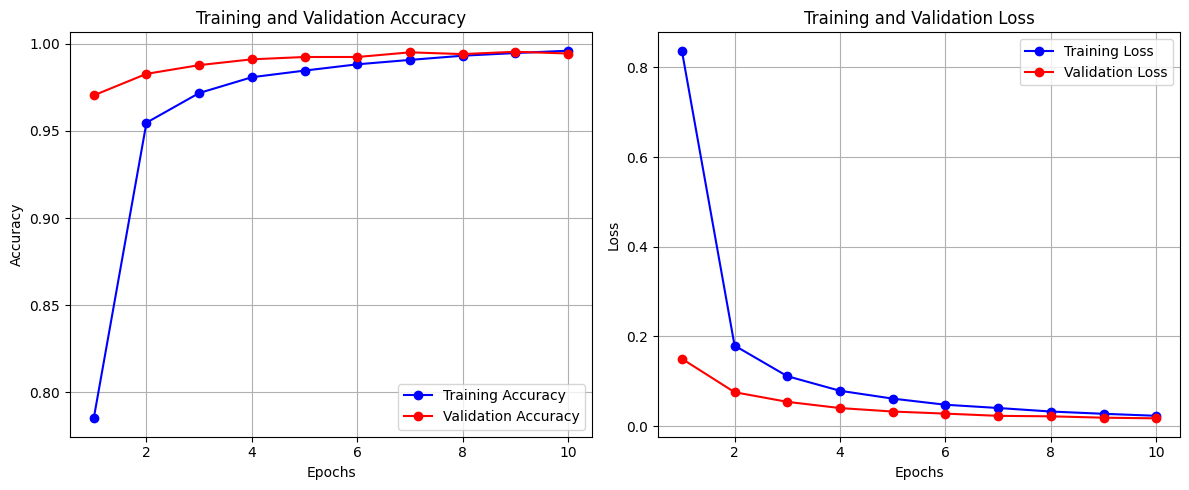

In [14]:
import matplotlib.pyplot as plt

# Plot Training and Validation Accuracy
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Accuracy Plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_training_history(history)


In [16]:
# # Save the model in SavedModel format
# model.save('saved_model/vegetable_classifier')

# Save the model in HDF5 format
model.save('vegetable_classifier.h5')


In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Get class names
class_names = train_ds_raw.class_names

# Predict on test dataset and identify wrong predictions
wrong_indices = []
wrong_images = []
wrong_labels = []

for image_batch, label_batch in test_ds:
    predictions = model.predict(image_batch)
    y_true = label_batch.numpy()
    y_pred = np.argmax(predictions, axis=1)

    # Identify wrong predictions
    misclassified = np.where(y_true != y_pred)[0]
    
    for idx in misclassified:
        wrong_indices.append(idx)
        wrong_images.append(image_batch[idx].numpy())  # Store the image directly
        wrong_labels.append((y_true[idx], y_pred[idx]))  # Store true and predicted labels

    # Stop if we have enough wrong predictions for visualization (optional)
    if len(wrong_images) >= 9:
        break

# Plot wrong predictions
def plot_wrong_predictions(wrong_images, wrong_labels, class_names, num_images=9):
    plt.figure(figsize=(15, 15))
    for i in range(min(num_images, len(wrong_images))):
        plt.subplot(3, 3, i + 1)
        plt.imshow(wrong_images[i])
        true_label, pred_label = wrong_labels[i]
        plt.title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_wrong_predictions(wrong_images, wrong_labels, class_names)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━

MemoryError: Unable to allocate 18.4 MiB for an array with shape (32, 224, 224, 3) and data type float32